In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import itertools
import seaborn as sns
from subprocess import check_output
%matplotlib inline

In [12]:
DATA_ROOT = Path('./template/1_data')

# データの読み込み
train_data = np.load(DATA_ROOT.joinpath('train_data.npy'))
train_label = np.load(DATA_ROOT.joinpath('train_label.npy'))
train_data = train_data.transpose(0, 2, 3, 1)
print("train data shape:", train_data.shape)
print("train label shape:", train_label.shape)

train data shape: (3000, 28, 28, 1)
train label shape: (3000, 15)


In [13]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2,
                                                    random_state=1234, shuffle=True)

In [30]:
X_train[0,:,:,0][0]

array([0.99607843, 0.99607843, 0.99607843, 0.99607843, 0.99607843,
       1.        , 1.        , 0.92156863, 0.6627451 , 0.827451  ,
       0.22352941, 1.        , 1.        , 0.99215686, 0.99607843,
       0.99607843, 0.99607843, 0.99607843, 0.99607843, 0.99607843,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99607843, 0.99607843, 0.99607843], dtype=float32)

In [53]:
y_train[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


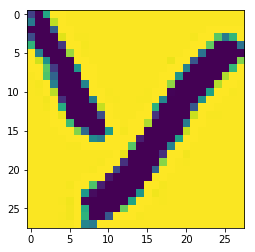

In [56]:
i = 3
print(y_train[i])
plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')

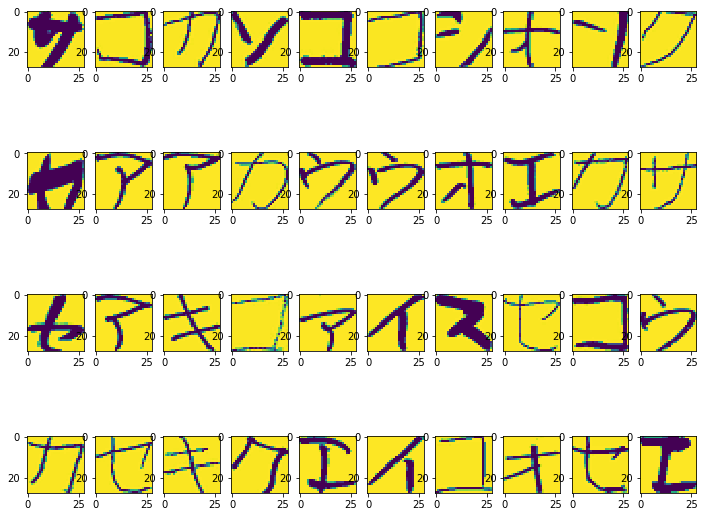

In [24]:
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [34]:
from src.models import load_model
from src.dataset import load_data

import tensorflow as tf
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.preprocessing import image

import os
import json
import numpy as np
from datetime import datetime

np.random.seed(1)
tf.set_random_seed(2)

In [84]:
config = {
    'batch_size': 80,
    'epochs': 100,
    'lr': 0.001
}

In [43]:
print("Parameters:", config)
# データの読み込み
x_train, x_test, y_train, y_test = load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# モデルの読み込み
model = load_model(config)

Parameters: {'batch_size': 80, 'epochs': 10, 'lr': 0.001}
train data shape: (3000, 28, 28, 1)
train label shape: (3000, 15)
(2400, 28, 28, 1) (600, 28, 28, 1) (2400, 15) (600, 15)


In [85]:
# Tensorboard
logdir = "log/run-{}/".format(datetime.utcnow().strftime("%Y%m%d%H%M%S"))
tb_cb = TensorBoard(log_dir=logdir,
                    histogram_freq=1,
                    write_images=1)
# Learning Rate Reducer
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=5,
                                 verbose=1,
                                 factor=0.8,
                                 min_lr=0.000001)
cbks = [tb_cb, lr_reduction]

In [86]:
# augmentation
datagen = image.ImageDataGenerator(shear_range=5,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )
gen = datagen.flow(x_train, y_train, batch_size=config["batch_size"])

x, y = next(gen)
print(x.shape, y.shape)
# 学習の実行
history = model.fit_generator(gen,
                              steps_per_epoch=len(x_train)/config["batch_size"],
                              epochs=config["epochs"],
                              callbacks=cbks,
                              validation_data=(x_test, y_test))

# モデルの構成確認
model.summary()

# テスト
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy', score[1])

# モデルの保存
model.save("./week8/models/katakana_model.h5")

(80, 28, 28, 1) (80, 15)
Epoch 1/100
30/30 [==============================] - 6s 201ms/step - loss: 0.1499 - acc: 0.9504 - val_loss: 0.1248 - val_acc: 0.9650
Epoch 2/100
30/30 [==============================] - 6s 201ms/step - loss: 0.1456 - acc: 0.9571 - val_loss: 0.1024 - val_acc: 0.9667
Epoch 3/100
30/30 [==============================] - 6s 200ms/step - loss: 0.1491 - acc: 0.9512 - val_loss: 0.1147 - val_acc: 0.9617
Epoch 4/100
30/30 [==============================] - 6s 199ms/step - loss: 0.1476 - acc: 0.9537 - val_loss: 0.0918 - val_acc: 0.9683
Epoch 5/100
30/30 [==============================] - 6s 203ms/step - loss: 0.1447 - acc: 0.9554 - val_loss: 0.0935 - val_acc: 0.9667
Epoch 6/100
30/30 [==============================] - 6s 203ms/step - loss: 0.1235 - acc: 0.9625 - val_loss: 0.0877 - val_acc: 0.9733
Epoch 7/100
30/30 [==============================] - 6s 202ms/step - loss: 0.1311 - acc: 0.9638 - val_loss: 0.1080 - val_acc: 0.9700
Epoch 8/100
30/30 [=========================

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

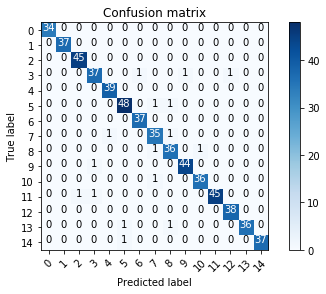

In [80]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15))

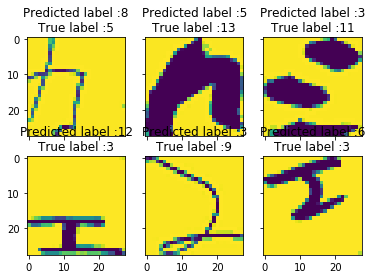

In [81]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


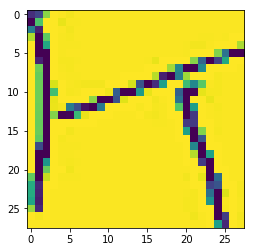

In [82]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

In [83]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.inputs, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


InvalidArgumentError: input_2:0 is both fed and fetched.

In [67]:
model.inputs

[<tf.Tensor 'input_2:0' shape=(?, 28, 28, 1) dtype=float32>]

In [76]:
test_im.reshape(1,28,28,1).shape

(1, 28, 28, 1)

In [77]:
activation_model.predict(test_im)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1c36a14400>>
Traceback (most recent call last):
  File "/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140510551486608


ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (28, 28, 1)